In [4]:
from verification.utils import load_jsonl
from verification.metrics import pass_at_n, cons_at_n, verify_at_n, weighted_cons_at_n, pess_at_n, monte_carlo_at_n
import numpy as np
from tqdm import tqdm

def score(data, N, R, alpha=0.5):
    return {
        "pass@N": 100 * monte_carlo_at_n(data, pass_at_n, N, R),
        "cons@N": 100 * monte_carlo_at_n(data, cons_at_n, N, R),
        "verify@N": 100 * monte_carlo_at_n(data, verify_at_n, N, R),
        "weighted_cons@N": 100 * monte_carlo_at_n(data, weighted_cons_at_n, N, R),
        "pess@N": 100 * monte_carlo_at_n(data, lambda inst, idxs: pess_at_n(inst, idxs, alpha), N, R),
    }

Figure 6 (Appendix C.1)

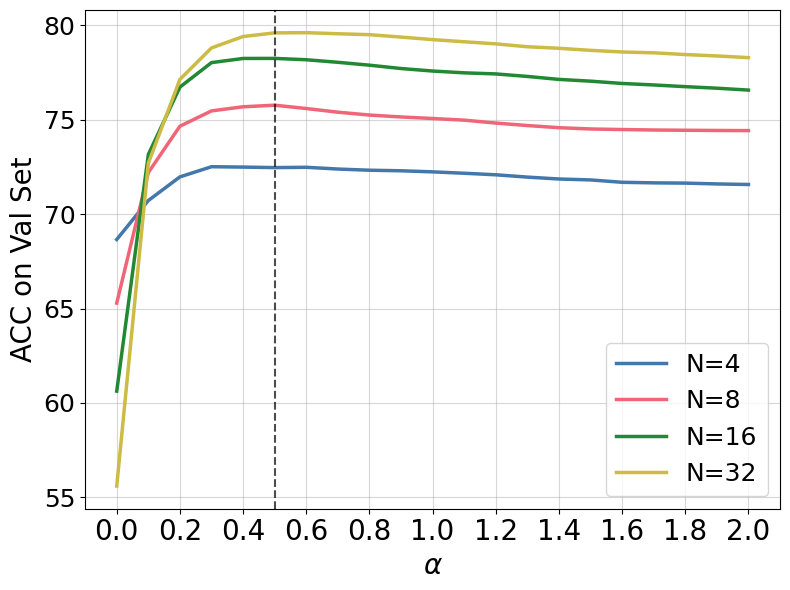

In [ ]:
import matplotlib.pyplot as plt

# Load val data and filter for 32B model
data = load_jsonl("../outputs/1.5b-no-thinking-0829/eval/val-0829.jsonl")
data = [x for x in data if x["llm_responses"][0]["model"] == "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B"]

# Paul Tol's colorblind-safe bright schema
colors = ["#4477AA", "#EE6677", "#228833", "#CCBB44", "#AA3377", "#66CCEE"]

# N values and alpha range
Ns = [4, 8, 16, 32]
R = 1000
alphas = np.linspace(0, 2, 21)

plt.figure(figsize=(8, 6))

for i, N in enumerate(Ns):
    accuracies = []
    for alpha in alphas:
        acc = 100 * monte_carlo_at_n(data, lambda inst, idxs: pess_at_n(inst, idxs, alpha), N, R)
        accuracies.append(acc)
    
    plt.plot(alphas, accuracies, label=f"N={N}", color=colors[i], linewidth=2.5)

# Add vertical line at alpha=0.5
plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.7, linewidth=1.5)

plt.xlabel(r"$\alpha$", fontsize=20)
plt.ylabel("ACC on Val Set", fontsize=20)
plt.grid(True, alpha=0.5)
plt.legend(fontsize=18)
plt.xticks(np.arange(0, 2.2, 0.2), fontsize=20)
plt.yticks(fontsize=18)
plt.tight_layout()
# plt.show()
plt.savefig("../iclr_figs/val_alpha_vs_acc_N.pdf", format="pdf")

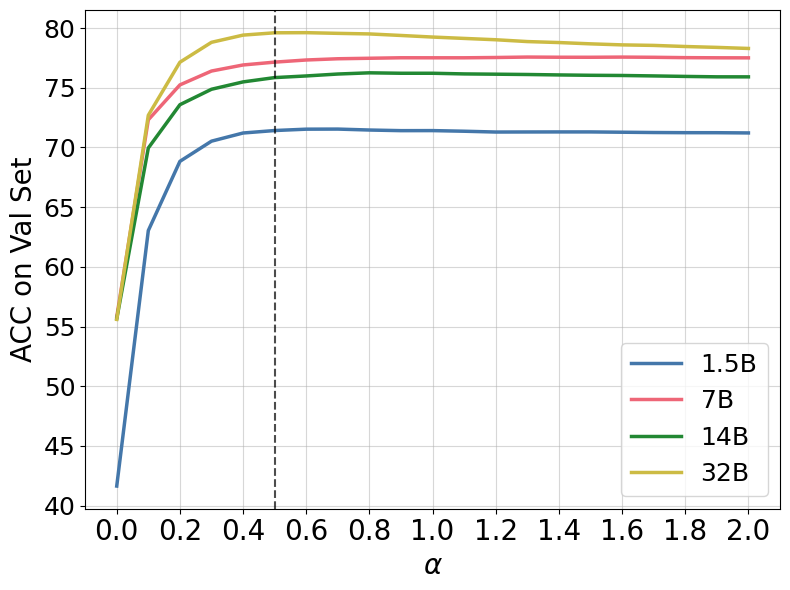

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load val data
data = load_jsonl("../outputs/1.5b-no-thinking-0829/eval/val-0829.jsonl")

# Models and Paul Tol's colorblind-safe bright schema
models = [
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B",
]
model_labels = ["1.5B", "7B", "14B", "32B"]
colors = ["#4477AA", "#EE6677", "#228833", "#CCBB44"]

# Fixed N and alpha range
N = 32
R = 1000
alphas = np.linspace(0, 2, 21)

plt.figure(figsize=(8, 6))

for i, model in enumerate(models):
    data_model = [x for x in data if x["llm_responses"][0]["model"] == model]
    accuracies = []
    for alpha in alphas:
        acc = 100 * monte_carlo_at_n(data_model, lambda inst, idxs: pess_at_n(inst, idxs, alpha), N, R)
        accuracies.append(acc)
    
    plt.plot(alphas, accuracies, label=f"{model_labels[i]}", color=colors[i], linewidth=2.5)

# Add vertical line at alpha=0.5
plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.7, linewidth=1.5)

plt.xlabel(r"$\alpha$", fontsize=20)
plt.ylabel("ACC on Val Set", fontsize=20)
plt.grid(True, alpha=0.5)
plt.legend(fontsize=18)
plt.xticks(np.arange(0, 2.2, 0.2), fontsize=20)
plt.yticks(fontsize=18)
plt.tight_layout()
# plt.show()
plt.savefig("../iclr_figs/val_alpha_vs_acc_size.pdf", format="pdf")

Table 1 Results (Sec 3)

In [ ]:
import random
import math

def score_data(data, metric_fn, N, R):
    # 1) accumulate successes over R replicates × len(data) instances
    successes = 0
    for _ in range(R):
        for inst in data:
            k = len(inst["llm_responses"])
            # draw one slate of size N WITH replacement
            slate = tuple(random.choices(range(k), k=N))
            if metric_fn(inst, slate):
                successes += 1

    # 2) compute point estimate and normal‐approx CI
    N_trials = R * len(data)
    p_hat = successes / N_trials            # fraction in [0,1]
    se    = math.sqrt(p_hat * (1 - p_hat) / N_trials)
    lo    = p_hat - 1.96 * se
    hi    = p_hat + 1.96 * se
    
    # return percentages
    return p_hat*100, se*100, lo*100, hi*100

N=32
R=1000

for dataset in ["aime2024", "aime2025", "livebench-math", "gpqa"]:
    data = load_jsonl(f"../outputs/1.5b-no-thinking-0829/eval/{dataset}.jsonl")
    data = [x for x in data if x["llm_responses"][0]["model"] == "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B"]

    print(f"== {dataset} ==")
    print(f"  # instances = {len(data)}")

    # pass@1
    p, se, lo, hi = score_data(data, pass_at_n, 1, R)
    print(f"  pass@1: {p:.1f}% ± {(1.96*se):.1f}%  (95% CI: [{lo:.1f}, {hi:.1f}]%)")

    # sc@N
    p, se, lo, hi = score_data(data, cons_at_n, N, R)
    print(f"  sc@{N}: {p:.1f}% ± {(1.96*se):.1f}%  (95% CI: [{lo:.1f}, {hi:.1f}]%)")

    # dv@N
    p, se, lo, hi = score_data(data, verify_at_n, N, R)
    print(f"  dv@{N}: {p:.1f}% ± {(1.96*se):.1f}%  (95% CI: [{lo:.1f}, {hi:.1f}]%)")

    # wsc@N
    p, se, lo, hi = score_data(data, weighted_cons_at_n, N, R)
    print(f"  wsc@{N}: {p:.1f}% ± {(1.96*se):.1f}%  (95% CI: [{lo:.1f}, {hi:.1f}]%)")

    # dpv@N
    p, se, lo, hi = score_data(data, lambda inst, idxs: pess_at_n(inst, idxs, 0.5), N, R)
    print(f"  dpv@{N}: {p:.1f}% ± {(1.96*se):.1f}%  (95% CI: [{lo:.1f}, {hi:.1f}]%)")

== aime2024 ==
  # instances = 30
  pass@1: 67.0% ± 0.5%  (95% CI: [66.4, 67.5]%)
  sc@32: 83.4% ± 0.4%  (95% CI: [83.0, 83.9]%)
  dv@32: 79.1% ± 0.5%  (95% CI: [78.7, 79.6]%)
  wsc@32: 85.6% ± 0.4%  (95% CI: [85.2, 86.0]%)
  dpv@32: 85.5% ± 0.4%  (95% CI: [85.1, 85.9]%)
== aime2025 ==
  # instances = 30
  pass@1: 51.9% ± 0.6%  (95% CI: [51.4, 52.5]%)
  sc@32: 66.6% ± 0.5%  (95% CI: [66.0, 67.1]%)
  dv@32: 60.8% ± 0.6%  (95% CI: [60.3, 61.4]%)
  wsc@32: 68.8% ± 0.5%  (95% CI: [68.3, 69.4]%)
  dpv@32: 69.1% ± 0.5%  (95% CI: [68.5, 69.6]%)
== livebench-math ==
  # instances = 368
  pass@1: 62.1% ± 0.2%  (95% CI: [62.0, 62.3]%)
  sc@32: 67.0% ± 0.2%  (95% CI: [66.8, 67.1]%)
  dv@32: 64.1% ± 0.2%  (95% CI: [64.0, 64.3]%)
  wsc@32: 67.5% ± 0.2%  (95% CI: [67.3, 67.6]%)
  dpv@32: 67.8% ± 0.2%  (95% CI: [67.7, 68.0]%)
== gpqa ==
  # instances = 198
  pass@1: 56.9% ± 0.2%  (95% CI: [56.7, 57.2]%)
  sc@32: 63.5% ± 0.2%  (95% CI: [63.3, 63.7]%)
  dv@32: 63.9% ± 0.2%  (95% CI: [63.7, 64.1]%)
  ws

Figure 5 (left) Section 3.3

In [ ]:

data = load_jsonl("../outputs/1.5b-no-thinking-0829/eval/aime2024.jsonl")
data = [x for x in data if x["llm_responses"][0]["model"] == "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B"]

pass_1 = 100 * monte_carlo_at_n(data, pass_at_n, 1, 1000)
Ns = [2, 4, 8, 16, 32, 64, 128]
pass_Ns = []
sc_Ns = []
dv_Ns = []
wsc_Ns = []
dpv_Ns = []

for N in tqdm(Ns):
    result = score(data, N, 1000)
    pass_Ns.append(result["pass@N"])
    sc_Ns.append(result["cons@N"])
    dv_Ns.append(result["verify@N"])
    wsc_Ns.append(result["weighted_cons@N"])
    dpv_Ns.append(result["pess@N"])

100%|██████████| 7/7 [00:59<00:00,  8.43s/it]


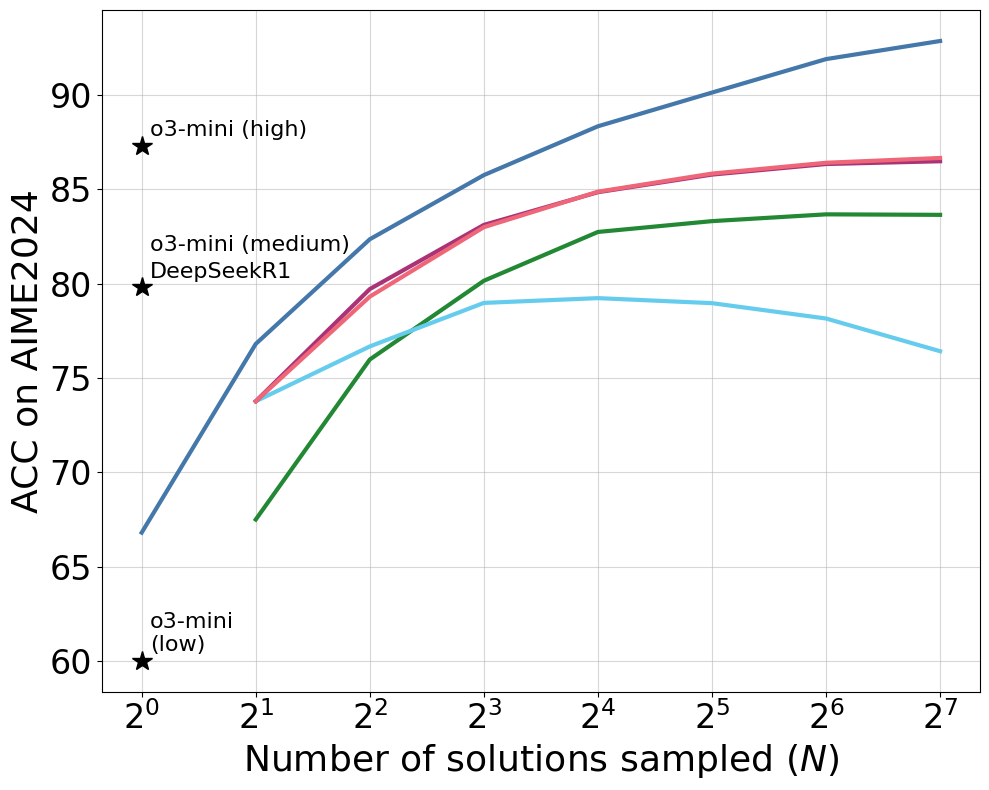

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

plt.plot([1]+Ns, [pass_1]+pass_Ns, label="Pass@N", color="#4477AA", linewidth=3)
plt.plot(Ns, sc_Ns, label="SC@N", color="#228833", linewidth=3)
plt.plot(Ns, dv_Ns, label="DV@N", color="#66CCEE", linewidth=3)
plt.plot(Ns, wsc_Ns, label="WSC@N", color="#AA3377", linewidth=3)
plt.plot(Ns, dpv_Ns, label="DPV@N", color="#EE6677", linewidth=3)

# DeepSeekR1
x, y = 1, 79.8
plt.plot(x, y, marker='*',markersize=15, color='black')
plt.text(x+0.05, y+0.3, 'DeepSeekR1', fontsize=16, verticalalignment='bottom', horizontalalignment='left', color='black')
plt.text(x+0.05, y+1.7, 'o3-mini (medium)', fontsize=16, verticalalignment='bottom', horizontalalignment='left', color='black')

x, y = 1, 87.3
plt.plot(x, y, marker='*',markersize=15, color='black')
plt.text(x+0.05, y+0.3, 'o3-mini (high)', fontsize=16, verticalalignment='bottom', horizontalalignment='left', color='black')

x, y = 1, 60.0
plt.plot(x, y, marker='*',markersize=15, color='black')
plt.text(x+0.05, y+0.3, 'o3-mini\n(low)', fontsize=16, verticalalignment='bottom', horizontalalignment='left', color='black')

plt.xscale("log", base=2)
plt.grid(True, alpha=0.5)
plt.xlabel("Number of solutions sampled $(N)$", fontsize=26)
plt.ylabel("ACC on AIME2024", fontsize=26)
plt.xticks([1, 2, 4, 8, 16, 32, 64, 128], fontsize=24)
plt.yticks(fontsize=24)
plt.tight_layout()
plt.savefig("../iclr_figs/aime2024_qwen32b_acc_vs_n_with_o3mini.pdf", format="pdf")
plt.show()

Figure 5 (right) Section 3.3

In [ ]:
from tqdm import tqdm

data = load_jsonl("../outputs/1.5b-no-thinking-0829/eval/aime2024-lengths.jsonl")
data = [x for x in data if x["llm_responses"][0]["model"] == "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B"]

lengths = [0, 512, 1024, 2048, 4096, 8192, 16384]
pass_Ns = []
sc_Ns = []
dv_Ns = []
wsc_Ns = []
dpv_Ns = []

for length in tqdm(lengths):
    data_length = [x for x in data if x["reasoning_length"] == length]
    result = score(data_length, 32, 1000)
    pass_Ns.append(result["pass@N"])
    sc_Ns.append(result["cons@N"])
    dv_Ns.append(result["verify@N"])
    wsc_Ns.append(result["weighted_cons@N"])
    dpv_Ns.append(result["pess@N"])

100%|██████████| 7/7 [00:17<00:00,  2.49s/it]


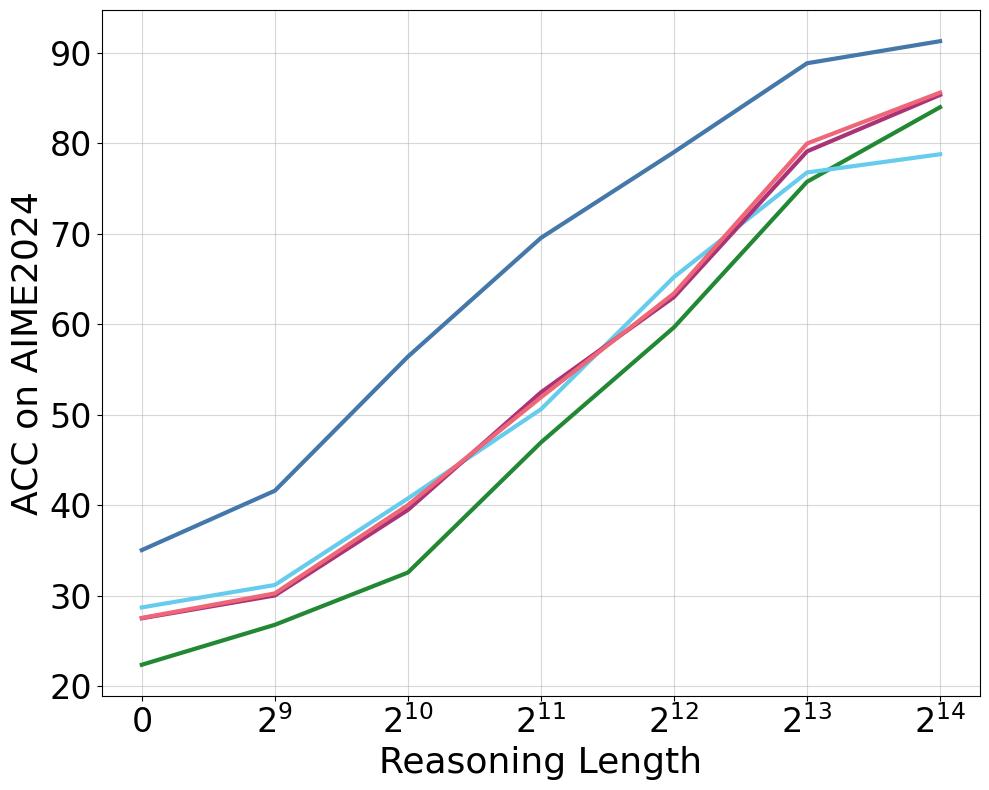

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
xs = [0, 1, 2, 3, 4, 5, 6]
plt.plot(xs, pass_Ns, label="Pass@N", color="#4477AA", linewidth=3)
plt.plot(xs, sc_Ns, label="SC@N", color="#228833", linewidth=3)
plt.plot(xs, dv_Ns, label="DV@N", color="#66CCEE", linewidth=3)
plt.plot(xs, wsc_Ns, label="WSC@N", color="#AA3377", linewidth=3)
plt.plot(xs, dpv_Ns, label="DPV@N", color="#EE6677", linewidth=3)

# plt.legend(fontsize=26)
plt.grid(True, alpha=0.5)
plt.xlabel("Reasoning Length", fontsize=26)
plt.ylabel("ACC on AIME2024", fontsize=26)
plt.xticks(xs, ["$0$", "$2^9$", "$2^{10}$", "$2^{11}$", "$2^{12}$", "$2^{13}$", "$2^{14}$"], fontsize=24)
plt.yticks(fontsize=24)
plt.tight_layout()
# plt.show()
plt.savefig("../iclr_figs/aime2024_qwen32b_acc_vs_reasoning_length.pdf", format="pdf")

Figure 4 subplots (Section 3.2)

In [ ]:
import matplotlib.pyplot as plt

data = load_jsonl("../outputs/1.5b-no-thinking-0829/eval/aime2024.jsonl") + load_jsonl("../outputs/1.5b-no-thinking-0829/eval/aime2025.jsonl")

# Fixed y-axis for all four plots
y_min, y_max = 35, 90
yticks = [40, 50, 60, 70, 80, 90]

for N in [8, 16, 32, 64]:

    models  = [
        "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
        "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B",
        "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B",
        "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B",
    ]
    model_sizes  = ["1.5B","7B","14B","32B"]

    R = 1000
    pass_Ns = []
    sc_Ns = []
    dv_Ns = []
    wsc_Ns = []
    dpv_Ns = []
    for model in models:

        data_model = [x for x in data if x["llm_responses"][0]["model"] == model]
        result = score(data_model, N, R)
        pass_Ns.append(result["pass@N"])
        sc_Ns.append(result["cons@N"])
        dv_Ns.append(result["verify@N"])
        wsc_Ns.append(result["weighted_cons@N"])
        dpv_Ns.append(result["pess@N"])

    plt.figure(figsize=(5, 5))
    plt.plot(model_sizes, pass_Ns, label=f"Pass@{N}", color="#4477AA", linewidth=3)
    plt.plot(model_sizes, sc_Ns, label=f"SC@{N}", color="#228833", linewidth=3)
    plt.plot(model_sizes, dv_Ns, label=f"DV@{N}", color="#66CCEE", linewidth=3)
    plt.plot(model_sizes, wsc_Ns, label=f"WSC@{N}", color="#AA3377", linewidth=3)
    plt.plot(model_sizes, dpv_Ns, label=f"DPV@{N}", color="#EE6677", linewidth=3)
    plt.xlabel("Solver Size", fontsize=22)
    plt.ylabel("ACC on AIME", fontsize=22)
    plt.grid(True, alpha=0.5)
    plt.xticks(fontsize=20)
    plt.yticks(yticks, fontsize=20)
    plt.ylim(y_min, y_max)
    plt.tight_layout()
    # plt.show()
    plt.savefig(f"../iclr_figs/aime_qwen32b_acc_vs_solver_size_{N}.pdf", format="pdf")
    plt.close()

Figure 2 (Section 2.2)

In [85]:
import pandas as pd
loss_data = pd.read_csv("wandb_export_2025-09-22T22_38_22.792-07_00.csv")
score_margin_data = pd.read_csv("wandb_export_2025-09-22T22_37_05.453-07_00.csv")

In [89]:
loss = list(loss_data["legendary-shape-82 - loss"])
score_margin = list(score_margin_data["legendary-shape-82 - score_margin"])

In [95]:
agg_loss = []
agg_score_margin = []
steps = []
for step, start_idx in enumerate(range(0, len(loss), 16)):
    agg_loss.append(sum(loss[start_idx:start_idx+16]) / 16)
    agg_score_margin.append(sum(score_margin[start_idx:start_idx+16]) / 16)
    steps.append(step)

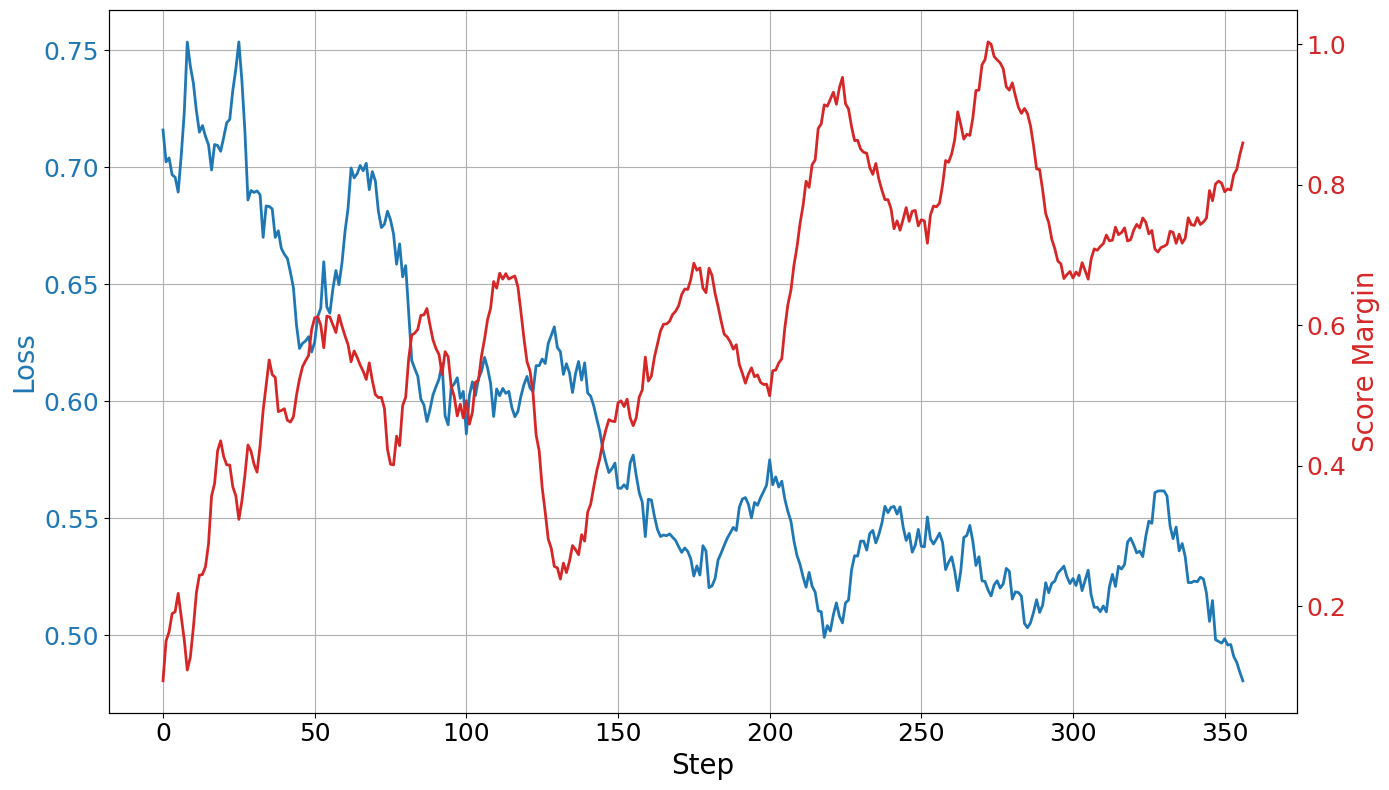

In [ ]:
df = pd.DataFrame({
    'step': steps,
    'loss': agg_loss,
    'margin': agg_score_margin
})

# 2) Compute a centered 20-step moving average (min_periods=1 so edges aren’t dropped)
window = 20
df['loss_ma']   = df['loss'] .rolling(window, center=True, min_periods=1).mean()
df['margin_ma'] = df['margin'].rolling(window, center=True, min_periods=1).mean()

# 3) Plot
fig, ax1 = plt.subplots(figsize=(14,8))

# Loss on left axis
color = 'tab:blue'
# ax1.plot(df['step'], df['loss'],    color=color, alpha=0.2)
ax1.plot(df['step'], df['loss_ma'], color=color,       label='Loss', linewidth=2)
ax1.set_xlabel('Step', fontsize=20)
ax1.set_ylabel('Loss', fontsize=20, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=18)
ax1.tick_params(axis='x', labelsize=18)
ax1.grid()

# Score margin on right axis
ax2 = ax1.twinx()
color = 'tab:red'
# ax2.plot(df['step'], df['margin'],    color=color, alpha=0.2)
ax2.plot(df['step'], df['margin_ma'], color=color,       label='Score Margin', linewidth=2)
ax2.set_ylabel('Score Margin', fontsize=20, color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=18)

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# ax1.legend(lines1 + lines2, labels1 + labels2,
#            loc='upper right', fontsize=18)

plt.tight_layout()
plt.savefig("../iclr_figs/training_loss_margin.pdf", format="pdf")

Appendix C.2 Figure 7

In [ ]:
from tqdm import tqdm

data = load_jsonl("../outputs/1.5b-no-thinking-0829/eval/val-0829.jsonl") + load_jsonl("../outputs/1.5b-no-thinking-0829/eval/val-0829.jsonl")
data = [x for x in data if x["llm_responses"][0]["model"] == "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B"]

Ns = [2, 4, 8, 16, 32, 64, 128]
pass_Ns_no_thinking = []
sc_Ns_no_thinking = []
dv_Ns_no_thinking = []
wsc_Ns_no_thinking = []
dpv_Ns_no_thinking = []

for N in tqdm(Ns):
    result = score(data, N, 1000)
    pass_Ns_no_thinking.append(result["pass@N"])
    sc_Ns_no_thinking.append(result["cons@N"])
    dv_Ns_no_thinking.append(result["verify@N"])
    wsc_Ns_no_thinking.append(result["weighted_cons@N"])
    dpv_Ns_no_thinking.append(result["pess@N"])

data = load_jsonl("../outputs/1.5b-0829/eval/val-0829.jsonl") + load_jsonl("../outputs/1.5b-0829/eval/val-0829.jsonl")
data = [x for x in data if x["llm_responses"][0]["model"] == "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B"]

pass_Ns_thinking = []
sc_Ns_thinking = []
dv_Ns_thinking = []
wsc_Ns_thinking = []
dpv_Ns_thinking = []

for N in tqdm(Ns):
    result = score(data, N, 1000)
    pass_Ns_thinking.append(result["pass@N"])
    sc_Ns_thinking.append(result["cons@N"])
    dv_Ns_thinking.append(result["verify@N"])
    wsc_Ns_thinking.append(result["weighted_cons@N"])
    dpv_Ns_thinking.append(result["pess@N"])

100%|██████████| 7/7 [01:13<00:00, 10.52s/it]


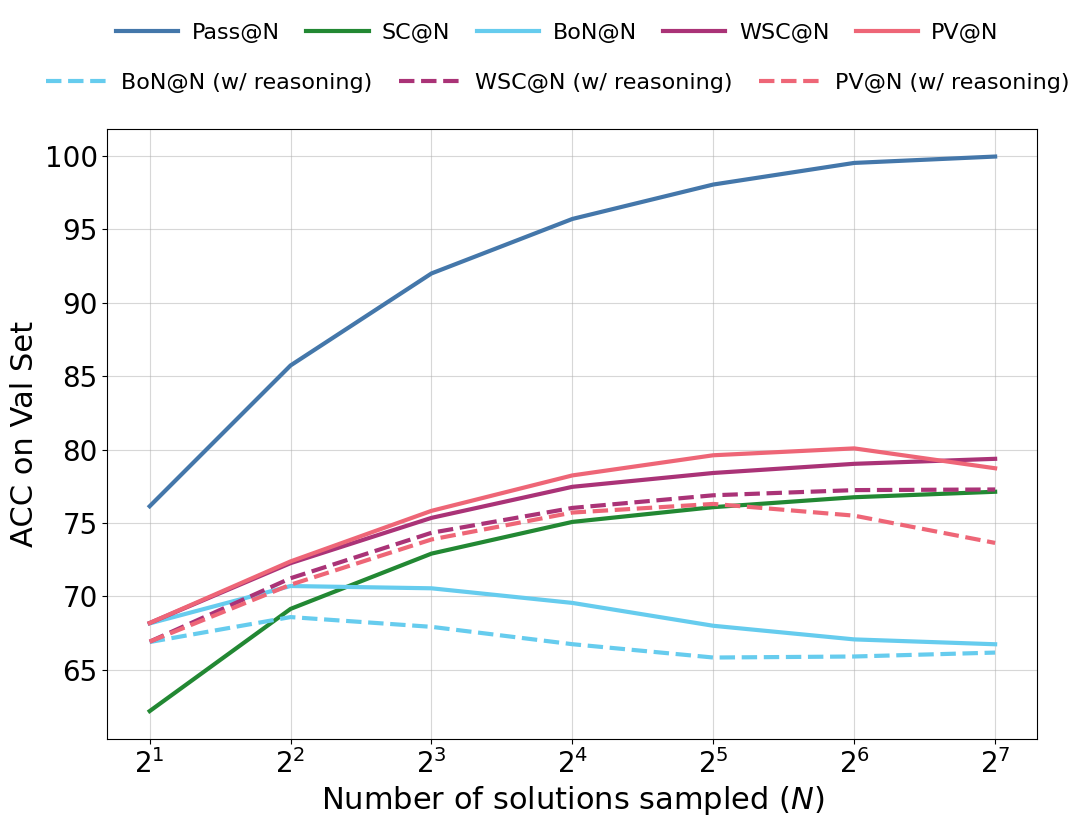

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

plt.plot(Ns, pass_Ns_no_thinking, label="Pass@N", color="#4477AA", linewidth=3)
plt.plot(Ns, sc_Ns_no_thinking, label="SC@N", color="#228833", linewidth=3)
plt.plot(Ns, dv_Ns_no_thinking, label="BoN@N", color="#66CCEE", linewidth=3)
plt.plot(Ns, wsc_Ns_no_thinking, label="WSC@N", color="#AA3377", linewidth=3)
plt.plot(Ns, dpv_Ns_no_thinking, label="PV@N", color="#EE6677", linewidth=3)

plt.plot(Ns, dv_Ns_thinking, label="BoN@N (w/ reasoning)", color="#66CCEE", linewidth=3, linestyle="--")
plt.plot(Ns, wsc_Ns_thinking, label="WSC@N (w/ reasoning)", color="#AA3377", linewidth=3, linestyle="--")
plt.plot(Ns, dpv_Ns_thinking, label="PV@N (w/ reasoning)", color="#EE6677", linewidth=3, linestyle="--")

plt.xscale("log", base=2)
plt.grid(True, alpha=0.5)
plt.xlabel("Number of solutions sampled $(N)$", fontsize=22)
plt.ylabel("ACC on Val Set", fontsize=22)
plt.xticks([2, 4, 8, 16, 32, 64, 128], fontsize=20)
plt.yticks(fontsize=20)

from matplotlib.lines import Line2D

# Expand figure to avoid horizontal squeeze and allow stacked legends
fig = plt.gcf()
fig.set_size_inches(12, 10, forward=True)

# Collect handles/labels in plotted order
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
label_to_handle = {lab: h for h, lab in zip(handles, labels)}

# Two independent legend rows
row1_labels = ["Pass@N", "SC@N", "BoN@N", "WSC@N", "PV@N"]
row2_labels = ["BoN@N (w/ reasoning)", "WSC@N (w/ reasoning)", "PV@N (w/ reasoning)"]
row1_handles = [label_to_handle[lbl] for lbl in row1_labels]
row2_handles = [label_to_handle[lbl] for lbl in row2_labels]

# First legend (top row)
leg1 = fig.legend(
    handles=row1_handles,
    labels=row1_labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.85),
    ncol=5,
    fontsize=16,
    frameon=False,
    fancybox=False,
    framealpha=1.0,
    handlelength=2.8,
    handletextpad=0.6,
    columnspacing=1.2,
    borderpad=0.6,
)

# Second legend (bottom row), centered below first
leg2 = fig.legend(
    handles=row2_handles,
    labels=row2_labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.8),
    ncol=3,
    fontsize=16,
    frameon=False,
    fancybox=False,
    framealpha=1.0,
    handlelength=2.8,
    handletextpad=0.6,
    columnspacing=1.2,
    borderpad=0.6,
)

# Reserve generous top margin so axes keep width and legends don't overlap
plt.subplots_adjust(top=0.72)

plt.savefig("../iclr_figs/val_qwen32b_acc_vs_n_thinking.pdf", format="pdf")
plt.show()

Figure 4/5 Legend

In [ ]:
import matplotlib.pyplot as plt

# … after you’ve drawn ax1 and ax2 …

labels     = ["Pass@N","SC@N","BoN@N", "WSC@N", "PV@N"]
colors     = ["#4477AA","#228833", "#66CCEE", "#AA3377", "#EE6677"]
linestyles = ["-"]*5
linewidth  = 2        # ← your desired line width

# make dummy handles with explicit lw:
dummy_handles = [
    Line2D([0],[0], color=c, ls=ls, lw=linewidth)
    for c, ls in zip(colors, linestyles)
]

fig = plt.gcf()
fig.legend(
    handles      = dummy_handles,
    labels       = labels,
    loc          = "upper center",
    ncol         = len(labels),
    frameon      = True,
    # edgecolor    = "gray",      # box outline color
    # facecolor    = "white",      # box fill
    handletextpad= 0.5,
    columnspacing= 1.0,
    bbox_to_anchor=(0.5, 1.02),
    bbox_transform=fig.transFigure
)

# shrink the top margin so the legend fits:
plt.subplots_adjust(top=0.80)

# when saving, use tight bounding box:
fig.savefig("../iclr_figs/model_scaling_legend.pdf", bbox_inches="tight", format="pdf")

<Figure size 640x480 with 0 Axes>

Figure 1 / Figure 3 Legend

In [ ]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

# … after you’ve drawn ax1 and ax2 …

labels     = ["SC@N","BoN@N","WSC@N","PV@N", "GPV@N,M"]
colors     = ["#228833","#66CCEE","#AA3377","#EE6677", "#CCBB44"]
linestyles = ["-"]*5
linewidth  = 2        # ← your desired line width

# make dummy handles with explicit lw:
dummy_handles = [
    Line2D([0],[0], color=c, ls=ls, lw=linewidth)
    for c, ls in zip(colors, linestyles)
]

fig = plt.gcf()
fig.legend(
    handles      = dummy_handles,
    labels       = labels,
    loc          = "upper center",
    ncol         = len(labels),
    frameon      = True,
    # edgecolor    = "gray",      # box outline color
    # facecolor    = "white",      # box fill
    handletextpad= 0.5,
    columnspacing= 1.0,
    bbox_to_anchor=(0.5, 1.02),
    bbox_transform=fig.transFigure
)

# shrink the top margin so the legend fits:
plt.subplots_adjust(top=0.80)

# when saving, use tight bounding box:
fig.savefig("../iclr_figs/main_legend.pdf", bbox_inches="tight", format="pdf")

<Figure size 640x480 with 0 Axes>

Compute (FLOPs/Latency) constants (see scripts/compute_estimates.ipynb)

In [ ]:
# solver (BoN)
AVERAGE_SOLVER_INPUT_LENGTH=133
AVERAGE_SOLVER_OUTPUT_LENGTH=10602
AVERAGE_SOLVER_FLOPS_PER_SAMPLE=625131826708480
AVERAGE_SOLVER_LATENCY_PER_SAMPLE_N_1 = 273.074387550354
AVERAGE_SOLVER_LATENCY_PER_SAMPLE_N_2 = 276.6106116771698
AVERAGE_SOLVER_LATENCY_PER_SAMPLE_N_4 = 288.38619780540466
AVERAGE_SOLVER_LATENCY_PER_SAMPLE_N_8 = 448.35090923309326
AVERAGE_SOLVER_LATENCY_PER_SAMPLE_N_16 = 782.906281709671
AVERAGE_SOLVER_LATENCY_PER_SAMPLE_N_32 = 1439.957554101944
AVERAGE_SOLVER_LATENCY_PER_SAMPLE_N_64 = 2815.468241930008
AVERAGE_SOLVER_LATENCY_PER_SAMPLE_N_128 = 5514.078681468964

# dv/dpv/wsc
AVERAGE_DV_INPUT_LENGTH=5082
AVERAGE_DV_OUTPUT_LENGTH=1
AVERAGE_DV_FLOPS_PER_SAMPLE=12744068803584
AVERAGE_DV_LATENCY_PER_SAMPLE = 0.05195287466049194

# heimdall (gpv)
AVERAGE_HEIMDALL_INPUT_LENGTH=5525
AVERAGE_HEIMDALL_OUTPUT_LENGTH=10500
AVERAGE_HEIMDALL_FLOPS_PER_SAMPLE=980453982208000
AVERAGE_HEIMDALL_LATENCY_PER_SAMPLE_N_1 = 276.01961755752563
AVERAGE_HEIMDALL_LATENCY_PER_SAMPLE_N_2 = 279.4113857746124
AVERAGE_HEIMDALL_LATENCY_PER_SAMPLE_N_4 = 328.29437160491943
AVERAGE_HEIMDALL_LATENCY_PER_SAMPLE_N_8 = 496.405907869339
AVERAGE_HEIMDALL_LATENCY_PER_SAMPLE_N_16 = 912.8740525245667
AVERAGE_HEIMDALL_LATENCY_PER_SAMPLE_N_32 = 1711.8473834991455
AVERAGE_HEIMDALL_LATENCY_PER_SAMPLE_N_64 = 3334.3926618099213
AVERAGE_HEIMDALL_LATENCY_PER_SAMPLE_N_128 = 6580.33390879631
HEIMDALL_LATENCY_DICT = {"1": AVERAGE_HEIMDALL_LATENCY_PER_SAMPLE_N_1, "2": AVERAGE_HEIMDALL_LATENCY_PER_SAMPLE_N_2, "4": AVERAGE_HEIMDALL_LATENCY_PER_SAMPLE_N_4, "8": AVERAGE_HEIMDALL_LATENCY_PER_SAMPLE_N_8, "16": AVERAGE_HEIMDALL_LATENCY_PER_SAMPLE_N_16, "32": AVERAGE_HEIMDALL_LATENCY_PER_SAMPLE_N_32, "64": AVERAGE_HEIMDALL_LATENCY_PER_SAMPLE_N_64, "128": AVERAGE_HEIMDALL_LATENCY_PER_SAMPLE_N_128}
HEIMDALL_ACC_N_1 = [53, 53, 53, 53, 53, 53]
HEIMDALL_ACC_N_2 = [54.7, 60.2, 61.8, 62.1, 62.2, 62.3]
HEIMDALL_ACC_N_4 = [59.1, 65.8, 67.9, 68.6, 69.1, 69.3]
HEIMDALL_ACC_N_8 = [63.1, 69.5, 72.1, 73.2, 74, 74.3]
HEIMDALL_ACC_N_16 = [65.2, 72.1, 75.0, 76.2, 76.9, 77.1]
HEIMDALL_ACC_N_32 = [66.3, 74.0, 77.0, 78.2, 78.6, 78.8]
HEIMDALL_ACC_N_64 = [67.0, 76.0, 78.5, 79.4, 79.7, 79.9]
HEIMDALL_ACC_N_128 = [68.0, 78.0, 79.8, 80.4, 81.0, 81.3]
HEIMDALL_MATRIX_N_BY_M = np.array([HEIMDALL_ACC_N_1, HEIMDALL_ACC_N_2, HEIMDALL_ACC_N_4, HEIMDALL_ACC_N_8, HEIMDALL_ACC_N_16, HEIMDALL_ACC_N_32, HEIMDALL_ACC_N_64, HEIMDALL_ACC_N_128])
HEIMDALL_MATRIX_M_BY_N = HEIMDALL_MATRIX_N_BY_M.T

Figure 1

In [ ]:
sc_latency = [AVERAGE_SOLVER_LATENCY_PER_SAMPLE_N_1, AVERAGE_SOLVER_LATENCY_PER_SAMPLE_N_2, AVERAGE_SOLVER_LATENCY_PER_SAMPLE_N_4, AVERAGE_SOLVER_LATENCY_PER_SAMPLE_N_8, AVERAGE_SOLVER_LATENCY_PER_SAMPLE_N_16, AVERAGE_SOLVER_LATENCY_PER_SAMPLE_N_32, AVERAGE_SOLVER_LATENCY_PER_SAMPLE_N_64, AVERAGE_SOLVER_LATENCY_PER_SAMPLE_N_128]

dv_latency = [1*AVERAGE_DV_LATENCY_PER_SAMPLE, 2*AVERAGE_DV_LATENCY_PER_SAMPLE, 4*AVERAGE_DV_LATENCY_PER_SAMPLE, 8*AVERAGE_DV_LATENCY_PER_SAMPLE, 16*AVERAGE_DV_LATENCY_PER_SAMPLE, 32*AVERAGE_DV_LATENCY_PER_SAMPLE, 64*AVERAGE_DV_LATENCY_PER_SAMPLE, 128*AVERAGE_DV_LATENCY_PER_SAMPLE]
dv_latency = [x + y for x, y in zip(sc_latency, dv_latency)]

dv_data = load_jsonl("../outputs/1.5b-no-thinking-0829/eval/aime2025.jsonl")
dv_data = [x for x in dv_data if x["llm_responses"][0]["model"] == "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B"]

sc_acc = []
dv_acc = []
wsc_acc = []
dpv_acc = []

for N in tqdm([1, 2, 4, 8, 16, 32, 64, 128]):
    results = score(dv_data, N, 1000)
    sc_acc.append(results["cons@N"])
    dv_acc.append(results["verify@N"])
    wsc_acc.append(results["weighted_cons@N"])
    dpv_acc.append(results["pess@N"])

100%|██████████| 8/8 [01:06<00:00,  8.37s/it]


In [203]:
heimdall_latency = []
for i, M in enumerate([1, 2, 4, 8, 16, 32]):
    heimdall_latency_m = []
    for j, N in enumerate([1, 2, 4, 8, 16, 32, 64, 128]):
        heimdall_latency_m.append(sc_latency[j] + HEIMDALL_LATENCY_DICT[str(N)] * M)
    heimdall_latency.append(heimdall_latency_m)
heimdall_latency = np.array(heimdall_latency)

heimdall_acc = HEIMDALL_MATRIX_M_BY_N

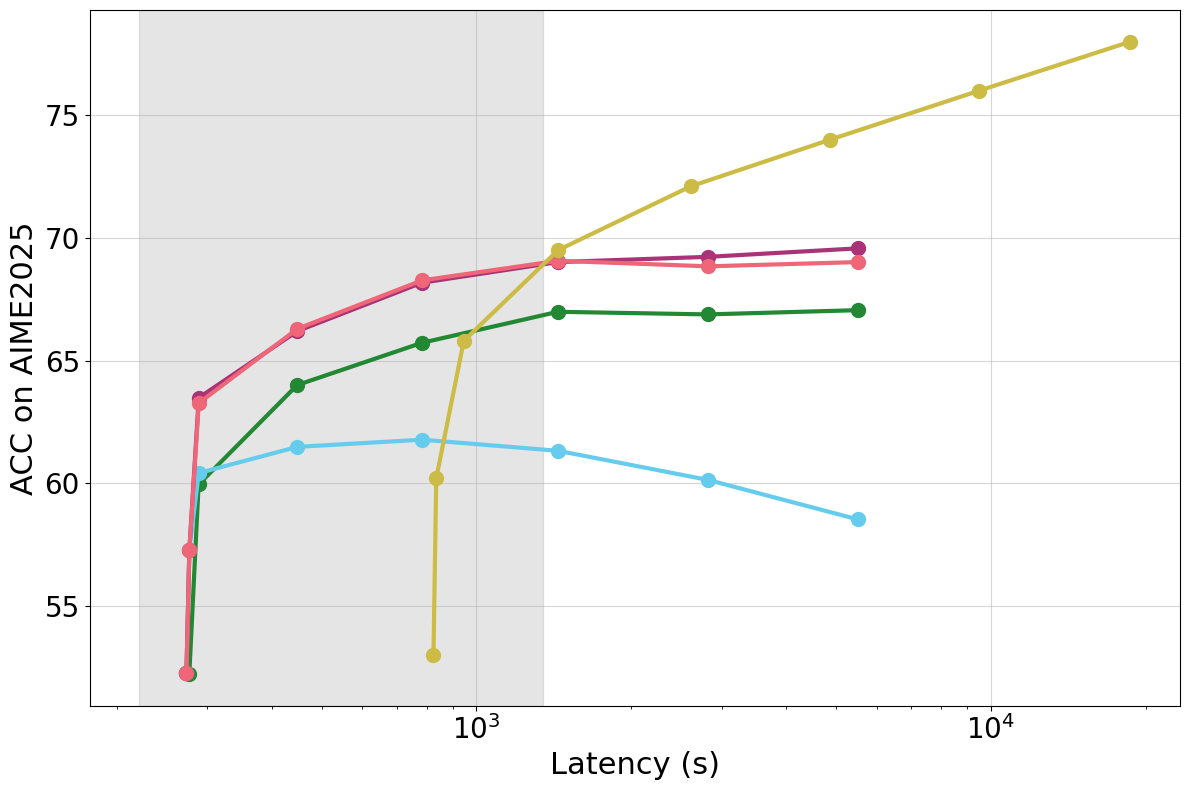

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

plt.plot(sc_latency, sc_acc, label="SC@N", color="#228833", linewidth=3, marker="o", markersize=10)
plt.plot(dv_latency, dv_acc, label="DV@N", color="#66CCEE", linewidth=3, marker="o", markersize=10)
plt.plot(dv_latency, wsc_acc, label="WSC@N", color="#AA3377", linewidth=3, marker="o", markersize=10)
plt.plot(dv_latency, dpv_acc, label="DPV@N", color="#EE6677", linewidth=3, marker="o", markersize=10)
# plt.plot(heimdall_latency[0], heimdall_acc[0], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
plt.plot(heimdall_latency[1], heimdall_acc[1], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o", markersize=10)
# plt.plot(heimdall_latency[2], heimdall_acc[2], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
# plt.plot(heimdall_latency[3], heimdall_acc[3], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
# plt.plot(heimdall_latency[4], heimdall_acc[4], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
# plt.plot(heimdall_latency[5], heimdall_acc[5], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")

# plt.legend(fontsize=16)
plt.xscale("log", base=10)
plt.grid(True, alpha=0.5)
plt.xlabel("Latency (s)", fontsize=22)
plt.ylabel("ACC on AIME2025", fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = plt.gca()
x_min, x_max = ax.get_xlim()
ax.axvspan(x_min, 1350, color='gray', alpha=0.2, zorder=0)

plt.tight_layout()
# plt.show()
plt.savefig("../iclr_figs/aime2025_qwen32b_acc_vs_latency_m_2.pdf", format="pdf")

Section 3.1.1 Figure 3

In [ ]:
sc_flops = [1*AVERAGE_SOLVER_FLOPS_PER_SAMPLE, 2*AVERAGE_SOLVER_FLOPS_PER_SAMPLE, 4*AVERAGE_SOLVER_FLOPS_PER_SAMPLE, 8*AVERAGE_SOLVER_FLOPS_PER_SAMPLE, 16*AVERAGE_SOLVER_FLOPS_PER_SAMPLE, 32*AVERAGE_SOLVER_FLOPS_PER_SAMPLE, 64*AVERAGE_SOLVER_FLOPS_PER_SAMPLE, 128*AVERAGE_SOLVER_FLOPS_PER_SAMPLE]

dv_flops = [1*AVERAGE_DV_FLOPS_PER_SAMPLE, 2*AVERAGE_DV_FLOPS_PER_SAMPLE, 4*AVERAGE_DV_FLOPS_PER_SAMPLE, 8*AVERAGE_DV_FLOPS_PER_SAMPLE, 16*AVERAGE_DV_FLOPS_PER_SAMPLE, 32*AVERAGE_DV_FLOPS_PER_SAMPLE, 64*AVERAGE_DV_FLOPS_PER_SAMPLE, 128*AVERAGE_DV_FLOPS_PER_SAMPLE]
dv_flops = [x + y for x, y in zip(sc_flops, dv_flops)]

dv_data = load_jsonl("../outputs/1.5b-no-thinking-0829/eval/aime2025.jsonl")
dv_data = [x for x in dv_data if x["llm_responses"][0]["model"] == "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B"]

sc_acc = []
dv_acc = []
wsc_acc = []
dpv_acc = []

for N in tqdm([1, 2, 4, 8, 16, 32, 64, 128]):
    results = score(dv_data, N, 1000)
    sc_acc.append(results["cons@N"])
    dv_acc.append(results["verify@N"])
    wsc_acc.append(results["weighted_cons@N"])
    dpv_acc.append(results["pess@N"])

100%|██████████| 8/8 [01:07<00:00,  8.43s/it]


In [209]:
heimdall_flops = []
for i, M in enumerate([1, 2, 4, 8, 16, 32]):
    heimdall_flops_m = []
    for j, N in enumerate([1, 2, 4, 8, 16, 32, 64, 128]):
        heimdall_flops_m.append(sc_flops[j] + (N * M * AVERAGE_HEIMDALL_FLOPS_PER_SAMPLE))
    heimdall_flops.append(heimdall_flops_m)
heimdall_flops = np.array(heimdall_flops)

heimdall_acc = HEIMDALL_MATRIX_M_BY_N

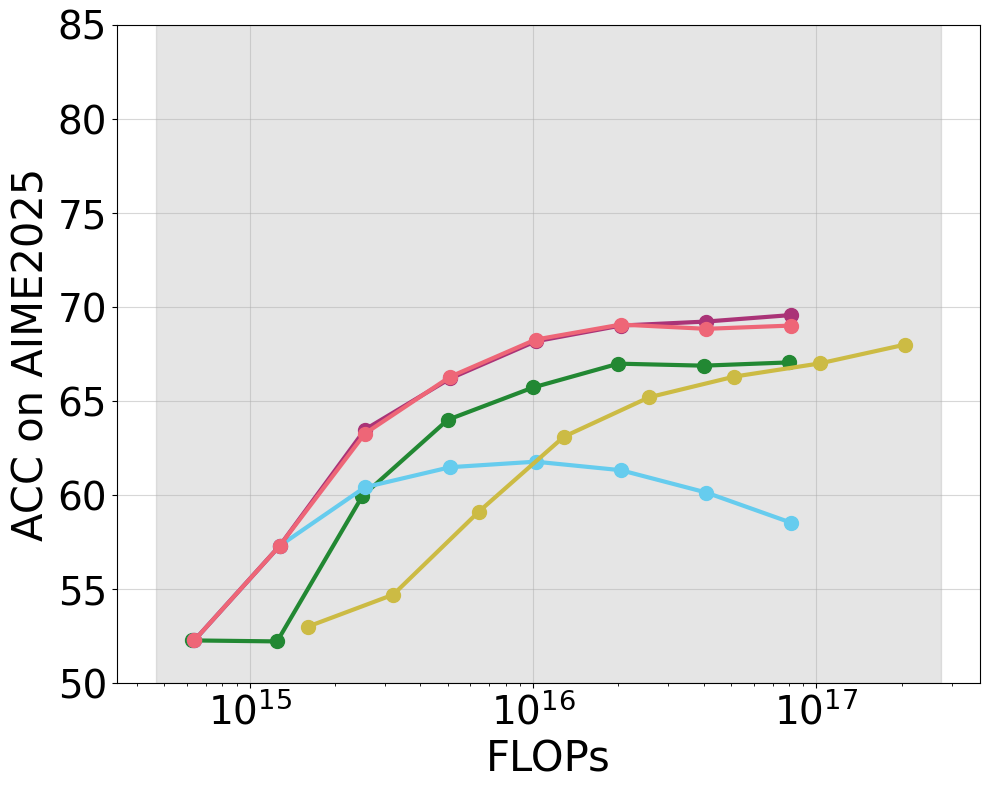

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

plt.plot(sc_flops, sc_acc, label="SC@N", color="#228833", linewidth=3, marker="o", markersize=10)
plt.plot(dv_flops, dv_acc, label="DV@N", color="#66CCEE", linewidth=3, marker="o", markersize=10)
plt.plot(dv_flops, wsc_acc, label="WSC@N", color="#AA3377", linewidth=3, marker="o", markersize=10)
plt.plot(dv_flops, dpv_acc, label="DPV@N", color="#EE6677", linewidth=3, marker="o", markersize=10)
plt.plot(heimdall_flops[0], heimdall_acc[0], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o", markersize=10)
# plt.plot(heimdall_flops[1], heimdall_acc[1], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
# # plt.plot(heimdall_flops[2], heimdall_acc[2], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
# # plt.plot(heimdall_flops[3], heimdall_acc[3], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
# # plt.plot(heimdall_flops[4], heimdall_acc[4], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
# # plt.plot(heimdall_flops[5], heimdall_acc[5], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")

# plt.legend(fontsize=16)
plt.xscale("log", base=10)
plt.grid(True, alpha=0.5)
plt.xlabel("FLOPs", fontsize=30)
plt.ylabel("ACC on AIME2025", fontsize=30)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

ax = plt.gca()
x_min, x_max = ax.get_xlim()
ax.axvspan(x_min, x_max, color='gray', alpha=0.2, zorder=0)

ax.set_ylim(50, 85)
ax.set_yticks(np.arange(50, 86, 5))

plt.tight_layout()
# plt.show()
plt.savefig("../iclr_figs/aime2025_qwen32b_acc_vs_flops_m_1.pdf", format="pdf")

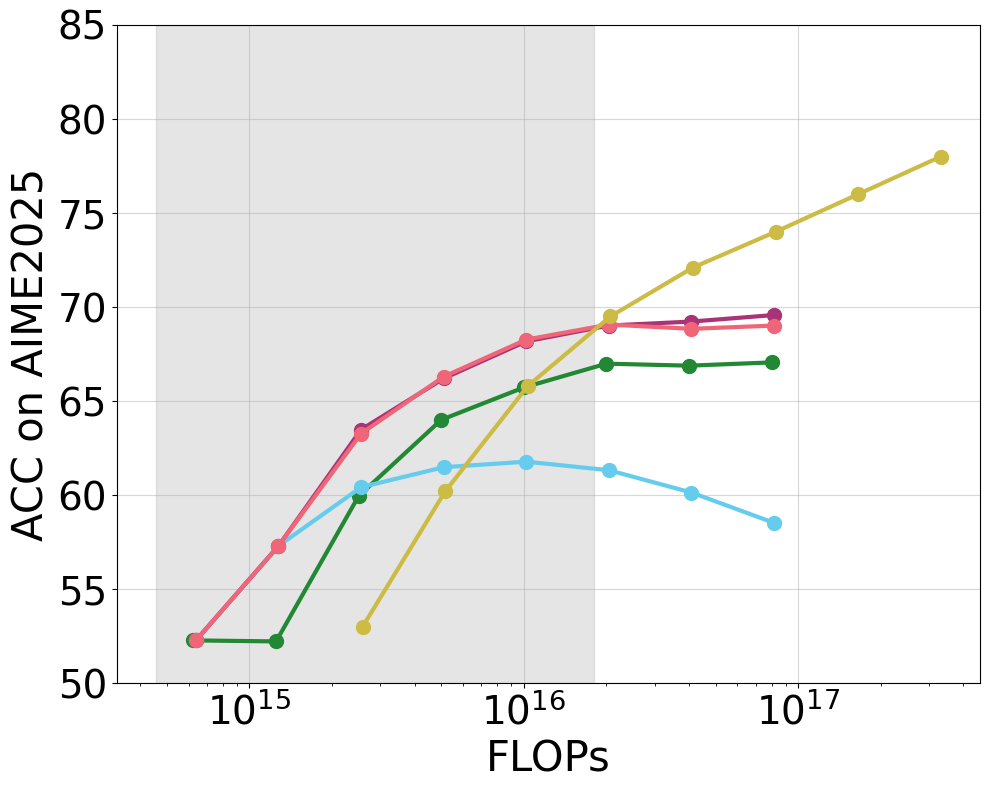

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

plt.plot(sc_flops, sc_acc, label="SC@N", color="#228833", linewidth=3, marker="o", markersize=10)
plt.plot(dv_flops, dv_acc, label="DV@N", color="#66CCEE", linewidth=3, marker="o", markersize=10)
plt.plot(dv_flops, wsc_acc, label="WSC@N", color="#AA3377", linewidth=3, marker="o", markersize=10)
plt.plot(dv_flops, dpv_acc, label="DPV@N", color="#EE6677", linewidth=3, marker="o", markersize=10)
# # plt.plot(heimdall_flops[0], heimdall_acc[0], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
plt.plot(heimdall_flops[1], heimdall_acc[1], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o", markersize=10)
# # plt.plot(heimdall_flops[2], heimdall_acc[2], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
# # plt.plot(heimdall_flops[3], heimdall_acc[3], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
# # plt.plot(heimdall_flops[4], heimdall_acc[4], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
# # plt.plot(heimdall_flops[5], heimdall_acc[5], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")

# plt.legend(fontsize=16)
plt.xscale("log", base=10)
plt.grid(True, alpha=0.5)
plt.xlabel("FLOPs", fontsize=30)
plt.ylabel("ACC on AIME2025", fontsize=30)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

ax = plt.gca()
x_min, x_max = ax.get_xlim()
ax.axvspan(x_min, 1.8e16, color='gray', alpha=0.2, zorder=0)
ax.set_ylim(50, 85)
ax.set_yticks(np.arange(50, 86, 5))

plt.tight_layout()
# plt.show()
plt.savefig("../iclr_figs/aime2025_qwen32b_acc_vs_flops_m_2.pdf", format="pdf")

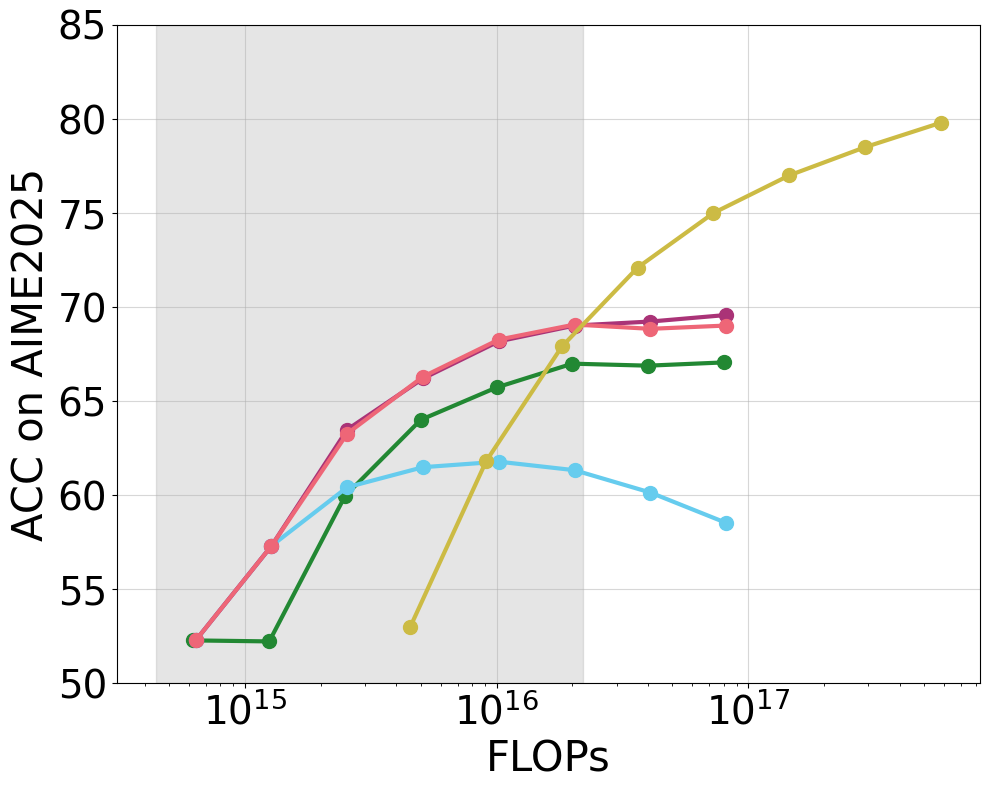

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

plt.plot(sc_flops, sc_acc, label="SC@N", color="#228833", linewidth=3, marker="o", markersize=10)
plt.plot(dv_flops, dv_acc, label="DV@N", color="#66CCEE", linewidth=3, marker="o", markersize=10)
plt.plot(dv_flops, wsc_acc, label="WSC@N", color="#AA3377", linewidth=3, marker="o", markersize=10)
plt.plot(dv_flops, dpv_acc, label="DPV@N", color="#EE6677", linewidth=3, marker="o", markersize=10)
# plt.plot(heimdall_flops[0], heimdall_acc[0], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
# plt.plot(heimdall_flops[1], heimdall_acc[1], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
plt.plot(heimdall_flops[2], heimdall_acc[2], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o", markersize=10)
# plt.plot(heimdall_flops[3], heimdall_acc[3], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
# plt.plot(heimdall_flops[4], heimdall_acc[4], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
# plt.plot(heimdall_flops[5], heimdall_acc[5], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")

# plt.legend(fontsize=16)
plt.xscale("log", base=10)
plt.grid(True, alpha=0.5)
plt.xlabel("FLOPs", fontsize=30)
plt.ylabel("ACC on AIME2025", fontsize=30)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

ax = plt.gca()
x_min, x_max = ax.get_xlim()
ax.axvspan(x_min, 2.2e16, color='gray', alpha=0.2, zorder=0)
ax.set_ylim(50, 85)
ax.set_yticks(np.arange(50, 86, 5))

plt.tight_layout()
# plt.show()
plt.savefig("../iclr_figs/aime2025_qwen32b_acc_vs_flops_m_4.pdf", format="pdf")

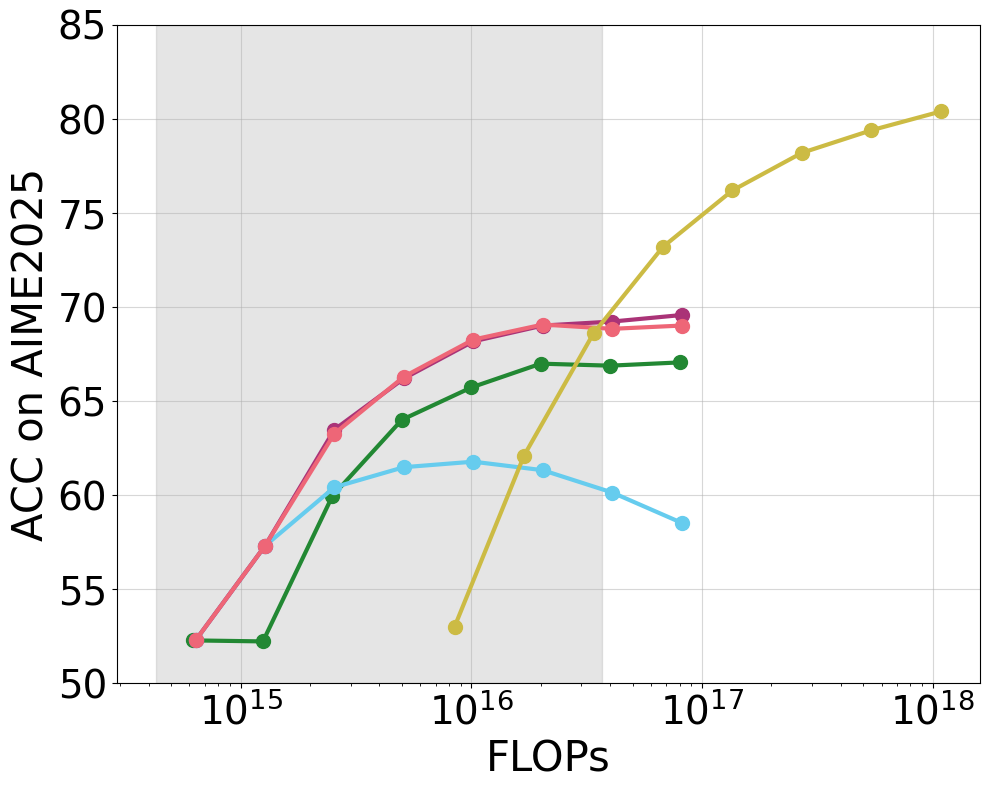

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

plt.plot(sc_flops, sc_acc, label="SC@N", color="#228833", linewidth=3, marker="o", markersize=10)
plt.plot(dv_flops, dv_acc, label="DV@N", color="#66CCEE", linewidth=3, marker="o", markersize=10)
plt.plot(dv_flops, wsc_acc, label="WSC@N", color="#AA3377", linewidth=3, marker="o", markersize=10)
plt.plot(dv_flops, dpv_acc, label="DPV@N", color="#EE6677", linewidth=3, marker="o", markersize=10)
# plt.plot(heimdall_flops[0], heimdall_acc[0], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
# plt.plot(heimdall_flops[1], heimdall_acc[1], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
# plt.plot(heimdall_flops[2], heimdall_acc[2], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
plt.plot(heimdall_flops[3], heimdall_acc[3], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o", markersize=10)
# plt.plot(heimdall_flops[4], heimdall_acc[4], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
# plt.plot(heimdall_flops[5], heimdall_acc[5], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")

# plt.legend(fontsize=16)
plt.xscale("log", base=10)
plt.grid(True, alpha=0.5)
plt.xlabel("FLOPs", fontsize=30)
plt.ylabel("ACC on AIME2025", fontsize=30)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

ax = plt.gca()
x_min, x_max = ax.get_xlim()
ax.axvspan(x_min, 3.7e16, color='gray', alpha=0.2, zorder=0)
ax.set_ylim(50, 85)
ax.set_yticks(np.arange(50, 86, 5))

plt.tight_layout()
# plt.show()
plt.savefig("../iclr_figs/aime2025_qwen32b_acc_vs_flops_m_8.pdf", format="pdf")

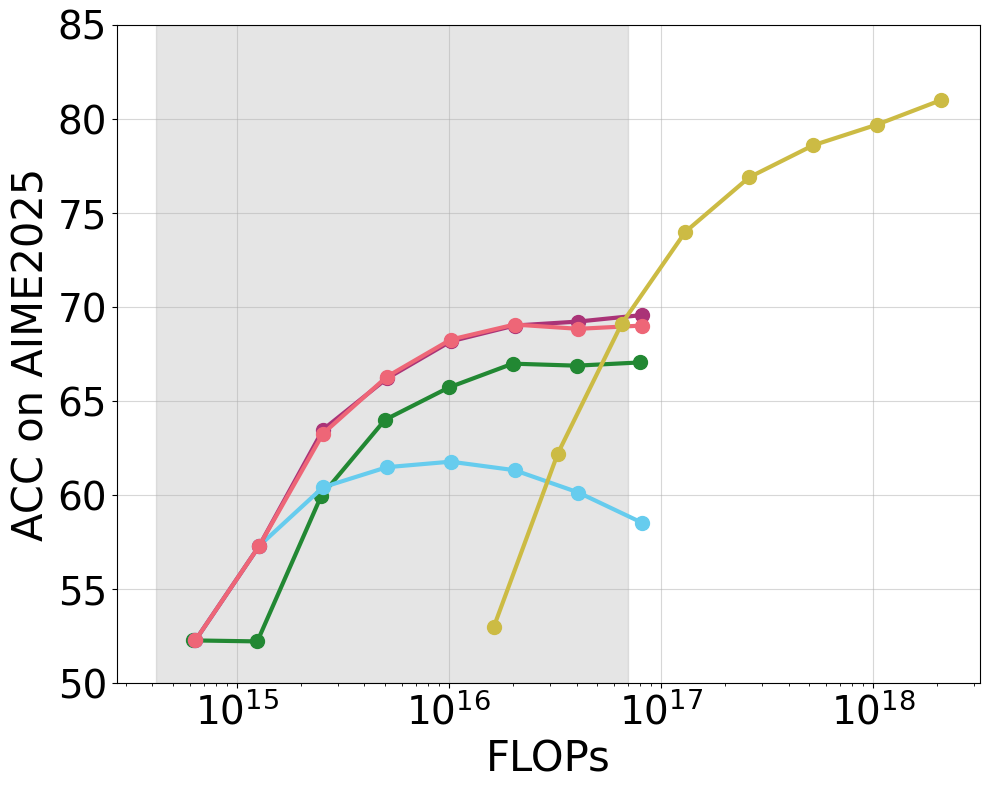

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

plt.plot(sc_flops, sc_acc, label="SC@N", color="#228833", linewidth=3, marker="o", markersize=10)
plt.plot(dv_flops, dv_acc, label="DV@N", color="#66CCEE", linewidth=3, marker="o", markersize=10)
plt.plot(dv_flops, wsc_acc, label="WSC@N", color="#AA3377", linewidth=3, marker="o", markersize=10)
plt.plot(dv_flops, dpv_acc, label="DPV@N", color="#EE6677", linewidth=3, marker="o", markersize=10)
# plt.plot(heimdall_flops[0], heimdall_acc[0], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
# plt.plot(heimdall_flops[1], heimdall_acc[1], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
# plt.plot(heimdall_flops[2], heimdall_acc[2], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
# plt.plot(heimdall_flops[3], heimdall_acc[3], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
plt.plot(heimdall_flops[4], heimdall_acc[4], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o", markersize=10)
# plt.plot(heimdall_flops[5], heimdall_acc[5], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")

# plt.legend(fontsize=16)
plt.xscale("log", base=10)
plt.grid(True, alpha=0.5)
plt.xlabel("FLOPs", fontsize=30)
plt.ylabel("ACC on AIME2025", fontsize=30)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

ax = plt.gca()
x_min, x_max = ax.get_xlim()
ax.axvspan(x_min, 7e16, color='gray', alpha=0.2, zorder=0)
ax.set_ylim(50, 85)
ax.set_yticks(np.arange(50, 86, 5))

plt.tight_layout()
# plt.show()
plt.savefig("../iclr_figs/aime2025_qwen32b_acc_vs_flops_m_16.pdf", format="pdf")

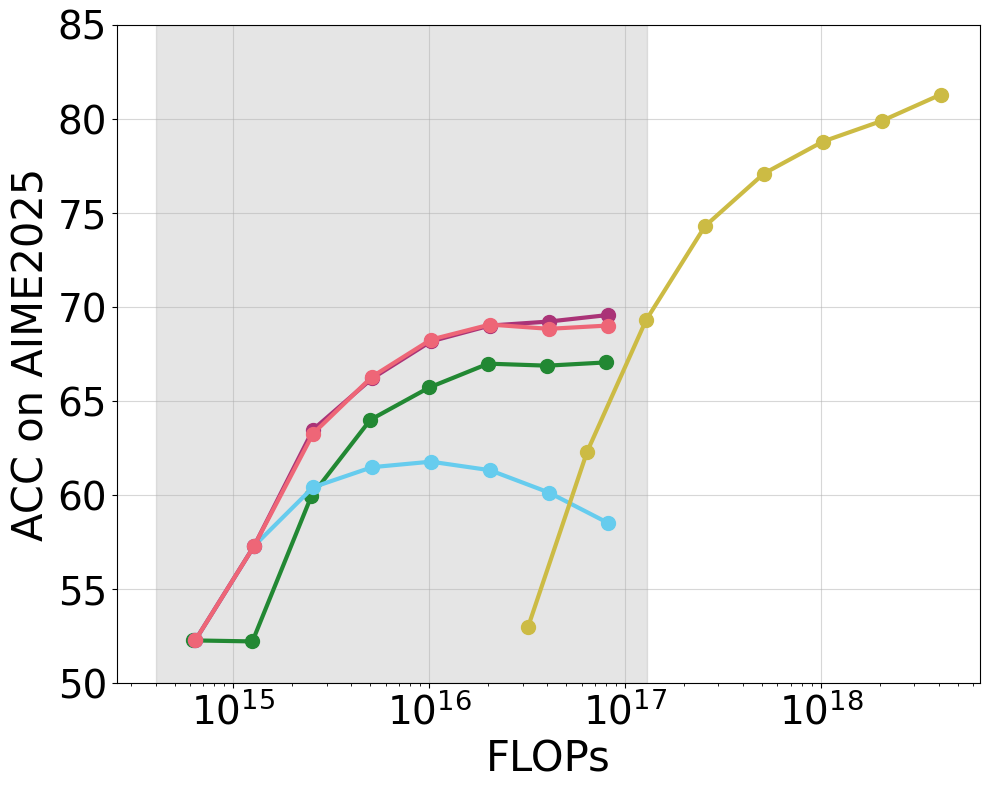

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

plt.plot(sc_flops, sc_acc, label="SC@N", color="#228833", linewidth=3, marker="o", markersize=10)
plt.plot(dv_flops, dv_acc, label="DV@N", color="#66CCEE", linewidth=3, marker="o", markersize=10)
plt.plot(dv_flops, wsc_acc, label="WSC@N", color="#AA3377", linewidth=3, marker="o", markersize=10)
plt.plot(dv_flops, dpv_acc, label="DPV@N", color="#EE6677", linewidth=3, marker="o", markersize=10)
# plt.plot(heimdall_flops[0], heimdall_acc[0], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
# plt.plot(heimdall_flops[1], heimdall_acc[1], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
# plt.plot(heimdall_flops[2], heimdall_acc[2], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
# plt.plot(heimdall_flops[3], heimdall_acc[3], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
# plt.plot(heimdall_flops[4], heimdall_acc[4], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o")
plt.plot(heimdall_flops[5], heimdall_acc[5], label="GPV@N (Heimdall)", color="#CCBB44", linewidth=3, marker="o", markersize=10)

# plt.legend(fontsize=16)
plt.xscale("log", base=10)
plt.grid(True, alpha=0.5)
plt.xlabel("FLOPs", fontsize=30)
plt.ylabel("ACC on AIME2025", fontsize=30)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

ax = plt.gca()
x_min, x_max = ax.get_xlim()
ax.axvspan(x_min, 1.3e17, color='gray', alpha=0.2, zorder=0)
ax.set_ylim(50, 85)
ax.set_yticks(np.arange(50, 86, 5))

plt.tight_layout()
# plt.show()
plt.savefig("../iclr_figs/aime2025_qwen32b_acc_vs_flops_m_32.pdf", format="pdf")